# Boundary conditions

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FBoundaryConditions.ipynb).

This notebook will give a tutorial on setting up boundary conditions in Tidy3d.

NOTE: the default boundary conditions (currently `Periodic()`) will change to `PML()` in Tidy3D version 2.0.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


[21:19:04] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=795780;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=896279;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#102\102]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.8.2                                                     ]8;id=494246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=106129;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#120\120]8;;\

## Define Simulation Parameters
First, we'll define some basc simulation parameters, the size of the domain, and the discretization resolution.

In [2]:
# Define material properties
medium = td.Medium(permittivity=2)

wavelength = 1
f0 = td.C_0 / wavelength / np.sqrt(medium.permittivity)

# Set the domain size in x, y, and z
domain_size = 12 * wavelength

# create the geometry
geometry = []

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

# Bandwidth in Hz
fwidth = f0 / 40.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.0

# time dependence of sources
source_time = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth


## Create sources and monitors
To study the effect of the various boundary conditions, we'll define a point dipole source and a series of frequency- and time-domain monitors in the volume of the simulation domain and at its edges.

In [3]:
# create a point dipole source
dipole = td.PointDipole(
    center=(0, 0, 0),
    source_time=source_time,
    polarization="Ex",
)

# these monitors will be used to plot fields on planes through the middle of the domain in the frequency domain
monitor_xz_freq = td.FieldMonitor(
    center=(0, 0, 0), size=(domain_size, 0, domain_size), freqs=[f0], name="xz_freq"
)
monitor_yz_freq = td.FieldMonitor(
    center=(0, 0, 0), size=(0, domain_size, domain_size), freqs=[f0], name="yz_freq"
)
monitor_xy_freq = td.FieldMonitor(
    center=(0, 0, 0), size=(domain_size, domain_size, 0), freqs=[f0], name="xy_freq"
)

# this monitor will be used to plot fields on a plane through the middle of the domain in the time domain
monitor_xz_time = td.FieldTimeMonitor(
    center=(0, 0, 0), size=(domain_size, 0, domain_size), interval=50, name="xz_time"
)


## Boundary specifications
A [`BoundarySpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.BoundarySpec.html) object defines the boundary conditions applied on each of the 6 domain edges, and is provided as an input to the simulation. In the following sections, we'll explore several different features within [`BoundarySpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.BoundarySpec.html) and different ways of defining it.

A [`BoundarySpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.BoundarySpec.html) consists of three [`Boundary`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Boundary.html) objects, each defining the boundaries on the plus and minus side of each dimension. A number of convenience functions are available to quickly define various types of boundaries, which will be demonstrated below.

### Example 1: Default PML boundaries along some dimensions

In most cases, one just wants to specify whether there are absorbing PML layers along any of the x, y, z dimensions.  To do this, we can call the `BoundarySpec.pml(x=False, y=False, z=False)` method to construct boundary conditions, supplying `True` along a dimension where we want PML.

NOTE: the default boundary conditions will change to PML() in Tidy3D version 2.0.

Let's try putting pml on only the x edge.

           WARNING  'BoundarySpec.y' uses default value, which is 'Periodic()' but will change to   ]8;id=538207;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=389737;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#605\605]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           WARNING  'BoundarySpec.z' uses default value, which is 'Periodic()' but will change to   ]8;id=955025;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=528411;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#605\605]8;;\
                    'PML()' in Tidy3D version 2.0. We recommend explicitly setting all boundary                    
                    conditions ahead of this release to avoid unexpected results.                                  

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=987369;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=482645;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

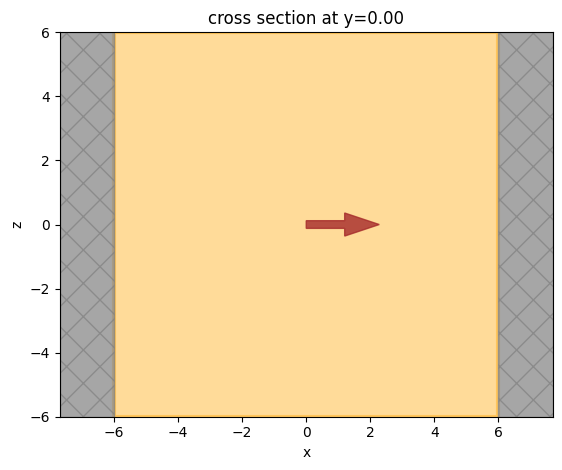

In [4]:
# define a basic boundary spec setting PML in along x only
bspec_pml = td.BoundarySpec.pml(x=True)

sim = td.Simulation(
    size=sim_size,
    sources=[dipole],
    monitors=[monitor_xz_time],
    run_time=run_time,
    boundary_spec=bspec_pml,
)

ax = sim.plot(y=0)


Now, let's test by placing PMLs along all edges using the convenience method `all_sides()` and running the simulation.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=975253;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=350480;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

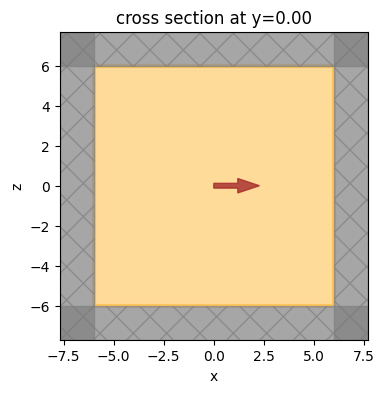

In [5]:
# define a basic boundary spec setting PML in all directions
bspec_pml = td.BoundarySpec.all_sides(boundary=td.PML())

# initialize the simulation object with the above boundary spec and source
sim = td.Simulation(
    size=sim_size,
    sources=[dipole],
    monitors=[monitor_xz_time],
    run_time=run_time,
    boundary_spec=bspec_pml,
)

# Visualize the geometry
fig, ax1 = plt.subplots(figsize=(4, 4))
sim.plot(y=0, ax=ax1)


In [6]:
sim_data = web.run(sim, task_name="bc_example1", path="data/bc_example1.hdf5")


           INFO     Using Tidy3D credentials from stored file.                                           ]8;id=810797;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=807332;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#70\70]8;;\

[21:19:08] INFO     Authentication successful.                                                           ]8;id=296694;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=492681;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#30\30]8;;\

[21:19:09] INFO     Created task 'bc_example1' with task_id '3fe39f07-ae91-46e8-8cba-b0ffd6edb96e'.   ]8;id=875480;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=400402;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[21:19:11] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=59377;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=114099;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=739323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=622615;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[21:19:13] INFO     status = preprocess                                                               ]8;id=594823;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=980194;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[21:19:16] INFO     starting up solver                                                                ]8;id=936935;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=995122;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[21:19:22] INFO     running solver                                                                    ]8;id=312190;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=290510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[21:19:26] INFO     early shutoff detected, exiting.                                                  ]8;id=816719;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=464256;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=552130;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=993378;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[21:19:28] INFO     status = success                                                                  ]8;id=470282;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=690097;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=654242;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=488892;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

[21:19:29] INFO     downloading file "output/monitor_data.hdf5" to "data/bc_example1.hdf5"            ]8;id=290183;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=253395;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[21:19:31] INFO     loading SimulationData from data/bc_example1.hdf5                                 ]8;id=743488;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=940899;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

#### Visualize results
We can observe the effect of the PML by looking at the fields in the time domain as they impinge on the boundaries. The figure shows that the fields are absorbed by the PML layers as expected, and no reflections are observed.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=677752;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=797389;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

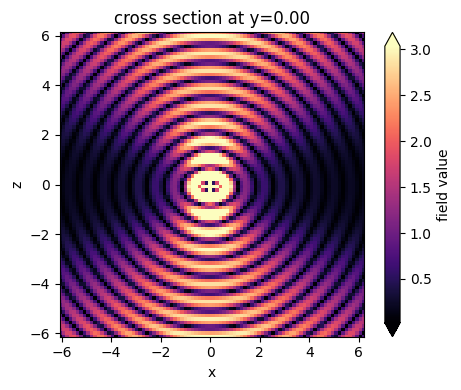

In [7]:
fig, ax = plt.subplots(tight_layout=True, figsize=(5, 4))
sim_data.plot_field(
    field_monitor_name="xz_time", field_name="Ex", y=0, val="abs", t=2e-13, ax=ax
)

plt.show()


### Example 2: different boundaries on different edges
Here, we'll place a PML along the y and z directions. In the x direction, we'll place a PML on the left side (x-minus), and a PEC on the right (x-plus). To specify individual boundary conditions along different dimensions, instead of [`BoundarySpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.BoundarySpec.html), the class [`Boundary`](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Boundary.html) is used, which defines the plus and minus boundaries along a single dimension.

We'll test this set of boundaries by placing an angled Gaussian beam near the lower edge of the domain and observing the field bounce off the PEC in x-plus.

In [8]:
# this defines a 1D boundary with a PML on both the plus and minus sides, which can be reused for both y and z directions
boundary_yz = td.Boundary.pml(num_layers=15)

# this defines a 1D boundary with a PML on the minus side and a PEC on the plus side
boundary_x = td.Boundary(minus=td.PML(), plus=td.PECBoundary())

# now just set these in the boundary spec along the appropriate dimensions
bspec_pml_pec = td.BoundarySpec(x=boundary_x, y=boundary_yz, z=boundary_yz)


# create the Gaussian beam source
buffer_source = (
    domain_size / 10
)  # distance between the source and the bottom of the domain
gaussian_beam = td.GaussianBeam(
    center=(0, 0, -domain_size / 2 + buffer_source),
    size=(td.inf, td.inf, 0),
    source_time=source_time,
    direction="+",
    pol_angle=0,
    angle_theta=np.pi / 4.0,
    angle_phi=np.pi / 8.0,
    waist_radius=wavelength * 2,
    waist_distance=-wavelength * 4,
)

# initialize the simulation object with the above boundary spec and source
sim = td.Simulation(
    size=sim_size,
    sources=[gaussian_beam],
    monitors=[monitor_xz_time],
    run_time=run_time,
    boundary_spec=bspec_pml_pec,
)


We can verify that the PML is placed only on the left hand side and not on the right.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=707270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=630163;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

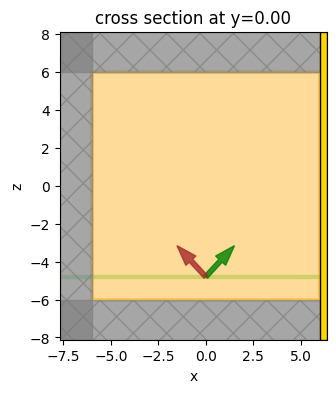

In [9]:
# Visualize the geometry
fig, ax1 = plt.subplots(figsize=(4, 4))
sim.plot(y=0, ax=ax1)


#### Run Simulation

In [10]:
sim_data = web.run(sim, task_name="bc_example2", path="data/bc_example2.hdf5")


[21:19:32] INFO     Created task 'bc_example2' with task_id '13c25c69-abda-41af-bdf2-b72abbe24f64'.   ]8;id=729376;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=237912;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[21:19:33] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=115763;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=932353;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=286321;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=755815;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[21:19:36] INFO     status = preprocess                                                               ]8;id=588298;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=316236;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[21:19:40] INFO     starting up solver                                                                ]8;id=702624;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=159994;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[21:19:44] INFO     running solver                                                                    ]8;id=965708;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=399252;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[21:19:47] INFO     early shutoff detected, exiting.                                                  ]8;id=145345;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=440687;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=749740;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=436357;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[21:19:50] INFO     status = success                                                                  ]8;id=196214;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=210646;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=542981;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=286205;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/bc_example2.hdf5"            ]8;id=359290;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=142859;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[21:19:52] INFO     loading SimulationData from data/bc_example2.hdf5                                 ]8;id=317644;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=339512;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

#### Visualize results
We can observe the effect of the PEC on x-plus by looking at the fields in the time domain as they bounce off the PEC boundary, as shown in the figure. Furthermore, the z-component of the electric field, which is tangential to the PEC boundary, goes to 0 at the boundary as expected.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=479020;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=391719;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

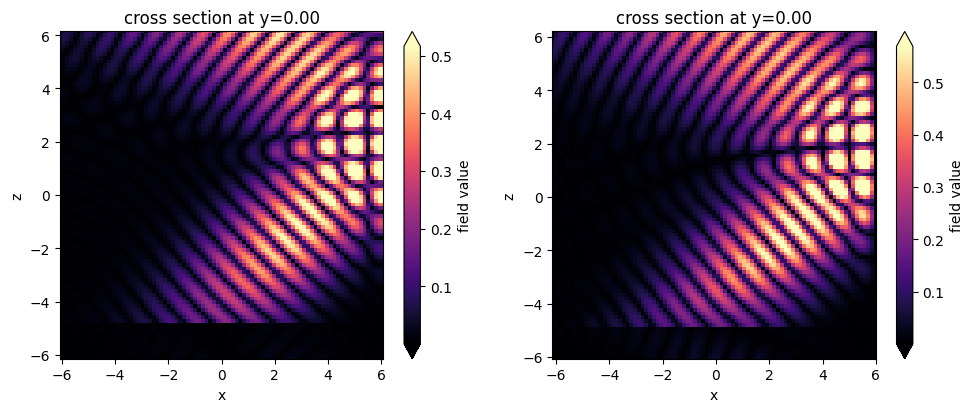

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data.plot_field(
    field_monitor_name="xz_time", field_name="Ex", y=0, val="abs", t=2e-13, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="xz_time", field_name="Ez", y=0, val="abs", t=2e-13, ax=ax2
)
plt.show()


### Example 3: different boundaries on different edges
Next, let's consider an even more general setup where all 6 boundaries of the domain are individually specified, and different types of boundaries are mixed in the plus and minus sides along each dimension.

We'll test this set of boundaries by placing the point dipole at the center of the domain again, this time studying the fields at the edges of the domain and checking that the various tangential field components satisfy the PEC and PMC boundary conditions as expected from theory.

[21:19:53] WARNING  A periodic boundary condition was specified on the opposide side of a perfect   ]8;id=569068;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py\boundary.py]8;;\:]8;id=660058;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/boundary.py#416\416]8;;\
                    electric or magnetic conductor boundary. This periodic boundary condition will                 
                    be replaced by the perfect electric or magnetic conductor across from it.                      

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=400270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=428349;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

<AxesSubplot: title={'center': 'cross section at x=0.00'}, xlabel='y', ylabel='z'>

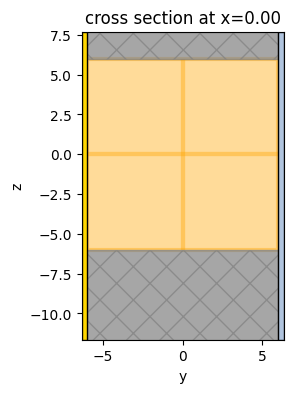

In [12]:
# define the boundary spec
bspec_general = td.BoundarySpec(
    x=td.Boundary(minus=td.Periodic(), plus=td.PECBoundary()),
    y=td.Boundary(minus=td.PECBoundary(), plus=td.PMCBoundary()),
    z=td.Boundary(minus=td.Absorber(), plus=td.PML()),
)
# note that when a periodic boundary is applied across from a PEC (PMC), the periodic boundary is just replaced by the PEC (PMC).


# initialize the simulation object with the above boundary spec and the dipole source from earlier
sim = td.Simulation(
    size=sim_size,
    sources=[dipole],
    monitors=[monitor_xz_freq, monitor_yz_freq, monitor_xy_freq],
    run_time=run_time,
    boundary_spec=bspec_general,
)

# Visualize the geometry
fig, ax1 = plt.subplots(figsize=(4, 4))
sim.plot(x=0, ax=ax1)


#### Run Simulation

In [13]:
sim_data = web.run(sim, task_name="bc_example3", path="data/bc_example3.hdf5")


           INFO     Created task 'bc_example3' with task_id '4d8c4fe6-12b0-4ca7-ba95-7aae25444728'.   ]8;id=997225;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=421370;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[21:19:55] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=31163;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=790340;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=180245;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=749557;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[21:19:58] INFO     status = preprocess                                                               ]8;id=24855;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=615834;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[21:20:01] INFO     starting up solver                                                                ]8;id=470044;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=876081;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[21:20:11] INFO     running solver                                                                    ]8;id=125828;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=246035;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

Output()

[21:20:20] INFO     status = postprocess                                                              ]8;id=138360;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=563211;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

[21:20:24] INFO     status = success                                                                  ]8;id=8470;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=836652;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=543783;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=590361;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/bc_example3.hdf5"            ]8;id=118930;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=952348;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[21:20:26] INFO     loading SimulationData from data/bc_example3.hdf5                                 ]8;id=739526;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=622662;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

           WARNING  Simulation final field decay value of 1.06e-05 is greater than the simulation     ]8;id=969381;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=726654;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#420\420]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

#### Visualize results
In x-plus, we have a PEC, so Ey and Ez should be nearly zero on the x-plus boundary.

In x-minus we have a periodic condition across from the PEC in x-plus, which just means that there's also a PEC in x-minus. So again Ey and Ez should be nearly zero on the x-minus boundary.

In y-minus, we have another PEC, so Ex and Ez should be nearly zero on the y-minus boundary.

In y-plus, we have a PMC, so Hx and Hz should be nearly zero on the y-plus boundary.

Each of these cases is verified below.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=479525;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=234975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

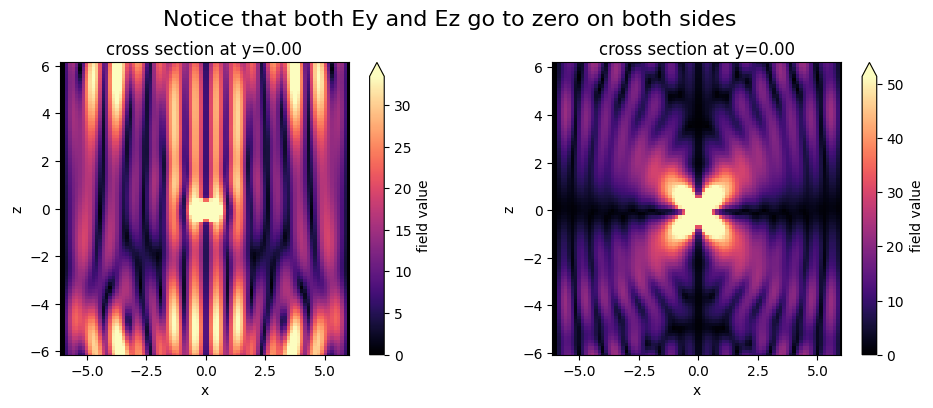

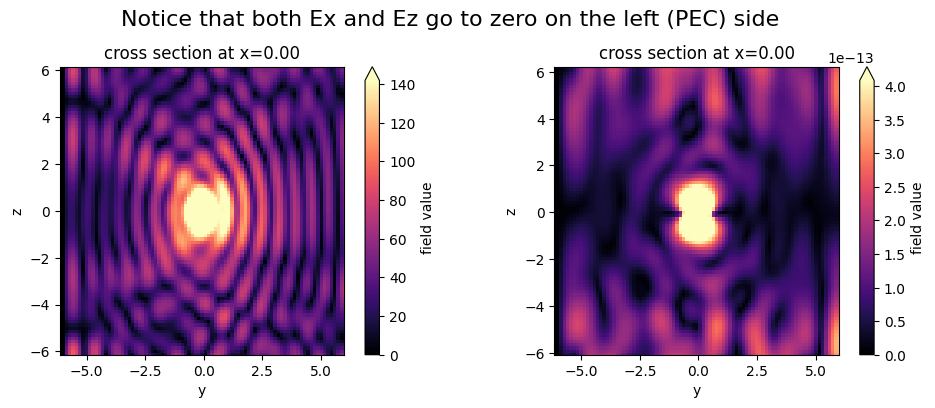

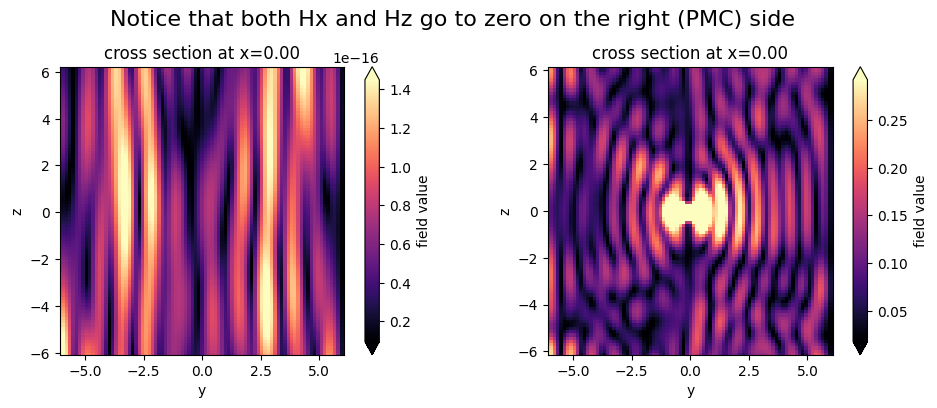

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data.plot_field(
    field_monitor_name="xz_freq", field_name="Ey", y=0, val="abs", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="xz_freq", field_name="Ez", y=0, val="abs", f=f0, ax=ax2
)
fig.suptitle("Notice that both Ey and Ez go to zero on both sides", fontsize=16)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Ex", x=0, val="abs", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Ez", x=0, val="abs", f=f0, ax=ax2
)
fig.suptitle(
    "Notice that both Ex and Ez go to zero on the left (PEC) side", fontsize=16
)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Hx", x=0, val="abs", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Hz", x=0, val="abs", f=f0, ax=ax2
)
fig.suptitle(
    "Notice that both Hx and Hz go to zero on the right (PMC) side", fontsize=16
)
plt.show()


### Example 4: Bloch boundary conditions along x and y to allow injecting an angled plane wave source
Finally, we'll use the Bloch boundary condition in combination with a plane wave source to demonstrate the injection of an angled plane wave. The Bloch boundaries are used along the x and y dimensions, while PMLs are used along z. The Bloch vectors are automatically computed based on the angles defined in the plane wave source. A dielectric background medium with a relative permittivity of 2 is used.

We'll test this set of boundaries by placing an angled plane wave near the lower edge of the domain and observing the plane wave in the frequency domain.

[21:20:28] INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=611426;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=891127;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

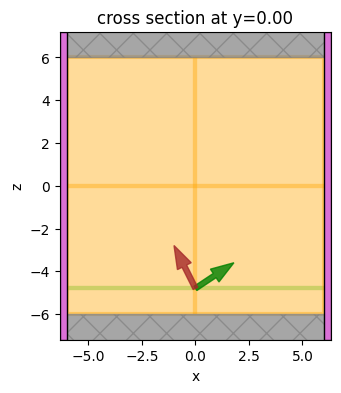

In [15]:
# First, define the plane wave source, since it is needed to define the Bloch boundary in this case.
# Note that in general, the Bloch boundary can also be defined by just providing a bandstructure-normalized Bloch vector.

buffer_source = (
    domain_size / 10
)  # distance between the source and the bottom of the domain
plane_wave = td.PlaneWave(
    center=(0, 0, -domain_size / 2 + buffer_source),
    size=(td.inf, td.inf, 0),
    source_time=source_time,
    direction="+",
    pol_angle=0,
    angle_theta=np.pi / 3.0,
    angle_phi=np.pi / 6.0,
)


# create the Bloch boundaries
bloch_x = td.Boundary.bloch_from_source(
    source=plane_wave, domain_size=sim_size[0], axis=0, medium=medium
)
bloch_y = td.Boundary.bloch_from_source(
    source=plane_wave, domain_size=sim_size[1], axis=1, medium=medium
)

bspec_bloch = td.BoundarySpec(x=bloch_x, y=bloch_y, z=td.Boundary.pml())


# initialize the simulation object with the above boundary spec and source
sim = td.Simulation(
    size=sim_size,
    sources=[plane_wave],
    monitors=[monitor_xz_freq, monitor_yz_freq, monitor_xy_freq],
    run_time=run_time,
    boundary_spec=bspec_bloch,
    medium=medium,
)

# Visualize the geometry
fig, ax1 = plt.subplots(figsize=(4, 4))
sim.plot(y=0, ax=ax1)


#### Run Simulation

In [16]:
sim_data = web.run(sim, task_name="bc_example4", path="data/bc_example4.hdf5")


           INFO     Created task 'bc_example4' with task_id '632414df-dc71-45dc-838c-3ce78c168ddd'.   ]8;id=972232;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=346717;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[21:20:30] INFO     status = queued                                                                   ]8;id=250385;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=858158;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[21:20:33] INFO     Maximum FlexUnit cost: 0.052                                                      ]8;id=645949;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=738557;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

[21:20:35] INFO     status = preprocess                                                               ]8;id=706509;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=889827;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[21:20:38] INFO     starting up solver                                                                ]8;id=774146;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=365718;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[21:20:47] INFO     running solver                                                                    ]8;id=682157;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=162459;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[21:20:50] INFO     early shutoff detected, exiting.                                                  ]8;id=193515;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=155236;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=989801;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=735243;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[21:20:54] INFO     status = success                                                                  ]8;id=607621;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=360394;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=17351;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=134603;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/bc_example4.hdf5"            ]8;id=925917;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=901522;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[21:20:57] INFO     loading SimulationData from data/bc_example4.hdf5                                 ]8;id=494969;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=760300;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

#### Visualize results
In shown in the plots, the plane wave is successfully injected at the specified angles without reflections.

           INFO     Auto meshing using wavelength 1.4142 defined from sources.                     ]8;id=508417;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=37193;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\

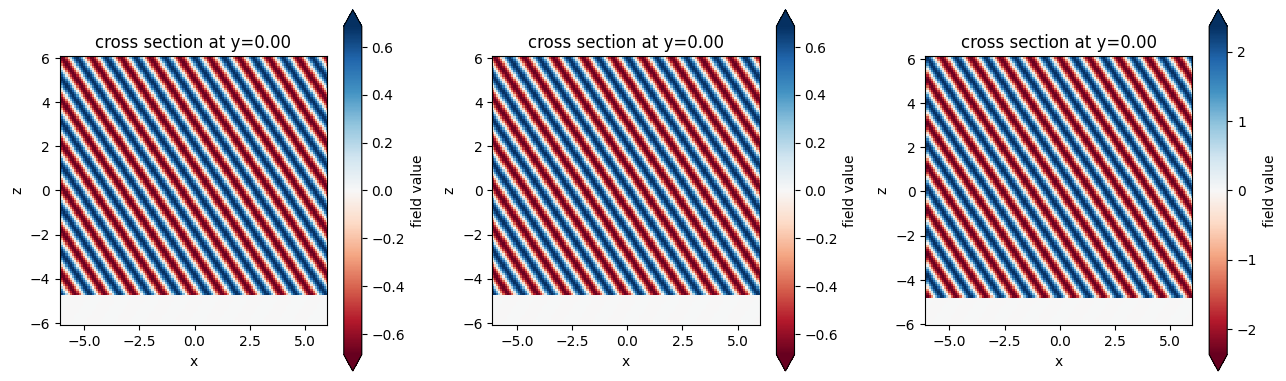

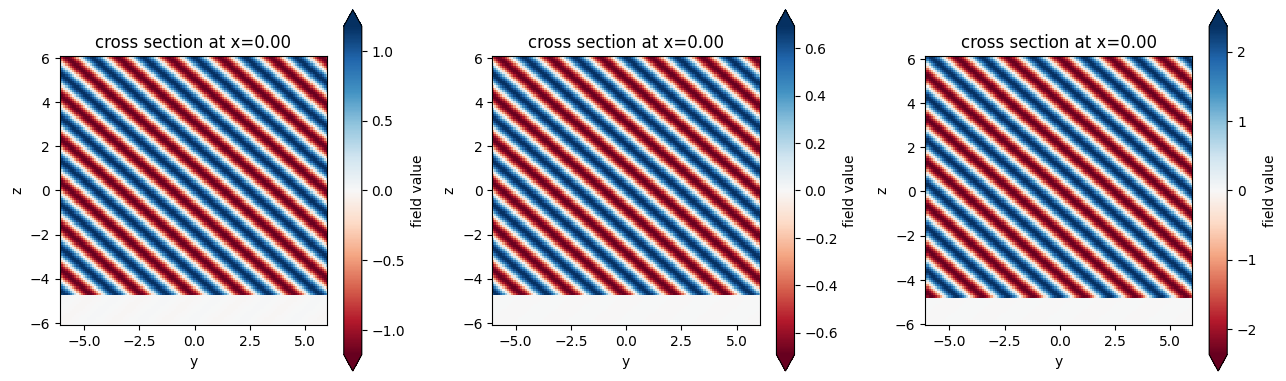

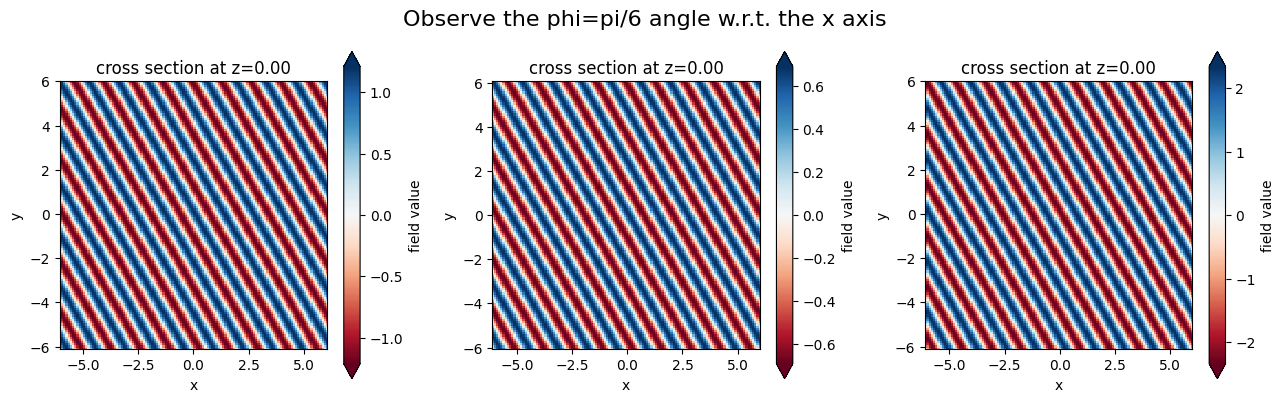

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(13, 4))
sim_data.plot_field(
    field_monitor_name="xz_freq", field_name="Ey", y=0, val="real", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="xz_freq", field_name="Ey", y=0, val="real", f=f0, ax=ax2
)
sim_data.plot_field(
    field_monitor_name="xz_freq", field_name="Ez", y=0, val="real", f=f0, ax=ax3
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(13, 4))
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Ex", x=0, val="real", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Ey", x=0, val="real", f=f0, ax=ax2
)
sim_data.plot_field(
    field_monitor_name="yz_freq", field_name="Ez", x=0, val="real", f=f0, ax=ax3
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(13, 4))
sim_data.plot_field(
    field_monitor_name="xy_freq", field_name="Ex", z=0, val="real", f=f0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="xy_freq", field_name="Ey", z=0, val="real", f=f0, ax=ax2
)
sim_data.plot_field(
    field_monitor_name="xy_freq", field_name="Ez", z=0, val="real", f=f0, ax=ax3
)
fig.suptitle("Observe the phi=pi/6 angle w.r.t. the x axis", fontsize=16)

plt.show()


## Summary

* The fastest way to define boundary conditions with periodic and absorbing boundaries on some sides is through `td.BoundarySpec.pml(y=True)` (i.e., for PML along y only), or through `td.BoundarySpec.all_sides(boundary=PML())` to set the same boundary on all sides (in this example, PML on all sides).

* To further fine tune the global boundary specifications, use [BoundarySpec(x, y, z)](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.BoundarySpec.html), where x, y, z are [Boundary](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Boundary.html) objects.

* [Boundary](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Boundary.html) objects have some convenience methods, like `.pml()` for defining the boundaries along an edge with more parameters.

* [Boundary](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Boundary.html) objects can be further specified by supplying boundary conditions to the `plus` and `minus` fields.
